# MC886 - Trabalho 2

### Fábio Camargo Ricci - 170781

### Leonardo Greco Picoli - 220090

### Divisão do trabalho
O trabalho foi dividido igualmente entre os integrantes, com colaboração de ambos em conjunto no desenvolvimento e discussão/análise de dados.

# Evolutionary Algorithm

In [2]:
# Importing stuff from pacman to run our Agents
import pacman
import textDisplay
import graphicsDisplay

# Importing other helpful libraries
from copy import deepcopy
from random import choice, choices, random, seed
from IPython.display import clear_output
import math
import matplotlib.pyplot as plt

import multiprocessing as mp

## Introdução ao modelo utilizado

Para resolver o problema do Pacman, o modelo evolucionário escolhido foi definido de tal forma que o 'cromossomo' de cada indíviduo fosse dependente do estado atual do jogo. Como referência, utilizamos o paper fornecido juntamente com o projeto.   
A estrutura de dados utilizada para representar os cromossomos de cada indivíduo é uma "SyntaxTree", uma árvore binária composta por dois tipos de nós diferentes: primitivos e terminais. Os nós primitivos são nós não-folhas e o valor de cada um é uma função matemática básica como soma, subtração, multiplicação, divisão, etc. Os nós terminais são nós folhas de valores numéricos. 
A classe abaixo define uma SyntaxTree básica com as funções: 
1. **max** (retona o maior valor entre o nó da esquerda e o da direita);
2. **min** (retorna o menor valor entre o nó da esquerda e o da direita);
3. **mean** (retorna a média aritmética entre o nó da esquerda e o da direita);
4. **sum** (retorna a soma entre o nó da esquerda e o da direita);
5. **sub** (retorna a subtração entre o nó da esquerda e o da direita);
6. **mul** (retorna a multiplicação entre o nó da esquerda e o da direita);
7. **div** (retorna a divisão entre o nó da esquerda e o da direita, ou 1 caso o valor do nó da direita seja nulo);



In [3]:
class Node:
    functions = {
        "max": lambda before, after: max(before, after),
        "min": lambda before, after: min(before, after),
        "mean": lambda before, after: (before + after) / 2,
        "sum": lambda before, after: before + after,
        "sub": lambda before, after: before - after,
        "mul": lambda before, after: before * after,
        "div": lambda before, after: before / after if after != 0 else 1,
    }
    consts = [-1.0, 0.0, 0.1, 0.5, 2.0, 5.0, 10.0]

    def __init__(self, func, before=None, after=None):
        self.function = func
        self.is_leaf = func not in Node.functions
        self.depth = 1
        self.before = None
        self.after = None
        self.set_before(before)
        self.set_after(after)
    
    def __call__(self, sensors={}):
        if self.is_leaf:
            if type(self.function) == str:
                assert self.function in sensors, "Leaf function not found in sensors dictionary"
                return sensors[self.function]
            return self.function
        return Node.functions[self.function](self.before(sensors), self.after(sensors))
    
    def set_before(self, node):
        self.before = node
        if node:
            self.depth = max(node.depth, self.after.depth if self.after else 0) + 1
    
    def set_after(self, node):
        self.after = node
        if node:
            self.depth = max(node.depth, self.before.depth if self.before else 0) + 1
    
    def __repr__(self):
        if self.is_leaf:
            return f"{self.function}"
        return f"{self.function}({self.before.__repr__()},{self.after.__repr__()})"

    def list_branches(self, min_depth=2):
        assert min_depth >= 2, "min_depth must be at least 2"
        if self.depth < min_depth:
            return []
        return [self] + self.before.list_branches(min_depth) + self.after.list_branches(min_depth)
    
    def __deepcopy__(self, memo=None):
        if self.is_leaf:
            return Node(self.function)
        return Node(self.function, deepcopy(self.before), deepcopy(self.after))

## Exemplo da estrutura utilizada no modelo

A instância de um **Node** representa uma SyntaxTree. De certa forma, cada SyntaxTree funciona como uma calculadora e o valor da raíz da árvore é também um valor numérico que depende recursivamente dos valores numéricos dos nós esquerdo e direito. A classe contém um método `__call__` que avalia exatamente o seu valor numérico. Segue um exemplo abaixo, que representa a árvore que calcula `(3 - 0) + 2`: 

In [4]:
soma = Node("sum", Node("sub", Node(3), Node(0)), Node(2))
print("Resultado:", soma())
print("Estrutura:", soma)

Resultado: 5
Estrutura: sum(sub(3,0),2)


## Exemplo do uso de sensores da estrutura

Até agora descrevemos árvores com nós folhas de valores numéricos constantes, mas gostaríamos de descrever árvores com nós folhas de valores que variam de acordo com os estados do jogo. O método `__call__` pode receber como argumento em sua chamada um dicionário de sensores, que são justamente os valores variáveis. Como exemplo, definimos uma estrutura que calcula a área de um círculo, e de certa forma passamos (através de sensores) como argumento o raio do círculo, assim não precisamos alterar diretamente os valores dos nós folhas da estrutura montada.

In [5]:
area_circulo = Node("mul", Node("mul", Node("raio"), Node("raio")), Node(3.1415926))
sensores = {"raio": 10.0}
print("Resultado:", area_circulo(sensores))
print("Estrutura:", area_circulo)

Resultado: 314.15926
Estrutura: mul(mul(raio,raio),3.1415926)


## Resultado final do modelo

O modelo final é tal que cada cromossomo é uma instância de um Node (SyntaxTree) com as funções definidas anteriormente aplicadas para os nós primitivos e com os terminais sendo os sensores do estado do jogo somados a valores constantes pré definidos.
As constantes pré definidas são `consts = [-1.0, 0.0, 0.1, 0.5, 2.0, 5.0, 10.0]`, enquanto os sensores do estado do jogo são: 

1. **dist_to_next_food:** Distância para a comida mais próxima;
2. **dist_to_next_pill:** Distância para a cápsula de poder mais próxima;
3. **dist_to_edible_ghost:** Distância para o fantasma mais próximo que pode ser comido;
4. **dist_to_non_edible_ghost:** Distância para o fantasma mais próximo que não pode ser comido;
5. **dist_to_next_junction:** Distância para junção mais próxima;
6. **ghost_before_junction:** Há um fantasma antes de uma junção;
7. **pill_before_ghost:** Há uma cápsula de poder antes de um fantasma;
8. **count_food:** Quantidade de comidas seguindo uma determinada direção;
9. **count_pill:** Quantidade de cápsulas de poder seguindo uma determinada direção;
10. **count_edible_ghost:** Quantidade de fantasmas comestíveis seguindo uma determinada direção;
11. **count_non_edible_ghost:** Quantidade de fantasmas não comestíveis seguindo uma determinada direção;
12. **count_junction:** Quantidade de junções seguindo uma determinada direção.

## A classe EvolutionaryForest

A classe EvolutionaryForest acopla todas as funções necessárias para realização de crossover, mutation, geração de indivíduos randômicos, e evaluate (atualização do fitness de cada indivíduo); guarda os principais parâmetros como: tamanho da população de cada geração, crossover rate, mutation rate, tamanho do torneio e tamanho dos indivíduos steady state (definido com a variável `elite_size`); e também é responsável por manter o vetor de indivíduos (`self.population`) de cada geração.


In [6]:
class EvolutionaryForest:
    def __init__(self, mutation_rate=0.2, crossover_rate=0.7, population_size=1000, tournament_size=10, max_generations=0, possible_sensors=[], genes_size=1, elite_size=5):
        self.max_depth = 20
        self.elite_size = elite_size
        self.tournament_size = tournament_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.max_generations = max_generations
        self.population_size = population_size
        self.possible_terminals = possible_sensors + Node.consts
        self.possible_primitives = list(Node.functions.keys())
        #
        self.population = [{
            "genes": [self.generate_random_tree(5,10) for _ in range(genes_size)],
            "fitness": 0
        } for _ in range(population_size)]
    
    def evaluate(self):
        for idx,ind in enumerate(self.population):
            fitness = sum([gene() for gene in ind["genes"]])
            x = ind["genes"][0]()
            func = abs(x**2 - 2)
            fitness = (1 / func) if func != 0 else float('inf')
            ind["fitness"] = fitness
    
    def evolve(self, epochs=1):
        for epoch in range(epochs):
            self.evaluate()
            best_ind = sorted(self.population, key=lambda x: x["fitness"])[-1]
            print(f"Generation {epoch} of {epochs}")
            gene = best_ind['genes'][0]
            #f"Fitness: {best_ind['fitness']}, 
            print(f"gene depth: {gene.depth}, gene value: {gene()}")
            self.next_generation()
    
    def select_roulette(self):
        # roulette method with applied linear normalization
        return choices(self.population, weights=[idx+1 for idx,_ in enumerate(self.population)])[0]
        
    def select_tournament(self):
        tournament_group = [choice(self.population) for _ in range(self.tournament_size)]
        return sorted(tournament_group, key=lambda x: x["fitness"])[-1]
    
    def select_couples(self, num_couples):
        for _ in range(num_couples):
            ind1 = self.select_roulette()
            ind2 = self.select_tournament()
            yield ind1, ind2

    def next_generation(self):
        self.population = sorted(self.population, key=lambda x: x["fitness"])
        new_population = self.population[-self.elite_size:]
        num_couples = (self.population_size - self.elite_size) // 2
        for ind1, ind2 in self.select_couples(num_couples):
            new_population.extend(self.breed(ind1, ind2))

        self.population = new_population

    def breed(self, ind1, ind2):
        new_ind1 = {"genes": [], "fitness": 0}
        new_ind2 = {"genes": [], "fitness": 0}
        
        for gene1, gene2 in zip(ind1['genes'], ind2['genes']):
            rand = random()
            
            if rand < self.mutation_rate + self.crossover_rate:
                new_gene1, new_gene2 = self.crossover(gene1, gene2)
                
                if rand < self.mutation_rate:
                    self.mutate(new_gene1)
                    self.mutate(new_gene2)
                    
                new_ind1["genes"].append(new_gene1)
                new_ind2["genes"].append(new_gene2)
            else:
                new_ind1["genes"].append(gene1)
                new_ind2["genes"].append(gene2)
                
        return new_ind1, new_ind2

    def mutate(self, gene):
        root = gene
        path_tree = [root]
        y = 1 / root.depth
        subtree = root.before if random() < 0.5 else root.after
        while random() > y and not subtree.is_leaf:
            path_tree.append(subtree)
            y = 1 / subtree.depth
            subtree = subtree.before if random() < 0.5 else subtree.after

        tree = path_tree[-1]
        d = random() < 0.5
        if subtree.is_leaf:
            new_subtree = self.generate_random_tree(1,min(3, self.max_depth - tree.depth))
            if d:
                tree.set_after(new_subtree)
            else:
                tree.set_before(new_subtree)
        else:
            if random() < 0.5:
                if d:
                    max_random_tree_depth = min(3, self.max_depth - tree.before.depth + 1)
                    new_subtree = self.generate_random_tree(1,max_random_tree_depth)
                    tree.set_after(new_subtree)
                else:
                    max_random_tree_depth = min(3, self.max_depth - tree.after.depth + 1)
                    new_subtree = self.generate_random_tree(1,max_random_tree_depth)
                    tree.set_before(new_subtree)
            else:
                subtree.function = choice(self.possible_primitives)
        
        # Update depth for all nodes when mutation is over
        while len(path_tree):
            tree = path_tree.pop()
            tree.depth = max(tree.before.depth, tree.after.depth) + 1

        return root

    def crossover(self, gene1, gene2):
        try:
            # gene1 chooses random subtree from gene2
            # gene1 decides where to put this subtree according to depth and max_depth
            copy1, copy2 = (deepcopy(gene1), deepcopy(gene2)) if gene1.depth < gene2.depth else (deepcopy(gene2), deepcopy(gene1))

            rand = random()
            tree1 = choice(copy1.list_branches())
            subtree1 = tree1.before if rand < 0.5 else tree1.after

            tree2 = choice([tree for tree in copy2.list_branches(min_depth=subtree1.depth+1) if tree.before.depth == subtree1.depth or tree.after.depth == subtree1.depth])
            if tree2.before.depth == subtree1.depth and tree2.after.depth == subtree1.depth:
                if rand < 0.5:
                    subtree2 = tree2.before
                    tree2.set_before(subtree1)
                else:
                    subtree2 = tree2.after
                    tree2.set_after(subtree1)
            elif tree2.before.depth == subtree1.depth:
                subtree2 = tree2.before
                tree2.set_before(subtree1)
            else:
                subtree2 = tree2.after
                tree2.set_after(subtree1)

            if rand < 0.5:
                tree1.set_before(subtree2)
            else:
                tree1.set_after(subtree2)
            return copy1, copy2
        except:
            print(f"gene1: {gene1}\n\ngene2: {gene2}\n\ntree1: {tree1}\n\nsubtree1: {subtree1}\n\n")
            return gene1, gene2

    def generate_random_tree(self, min_depth, max_depth):
        my_depth = choice(range(min_depth,max_depth+1))

        if my_depth == 1: #is_leaf
            return Node(choice(self.possible_terminals))

        root = Node(choice(self.possible_primitives))
        direction = choice([0,1]) # 0: before, 1: after

        if direction == 0:
            root.set_before(self.generate_random_tree(my_depth-1, my_depth-1))
            root.set_after(self.generate_random_tree(1, my_depth-1))
        else:
            root.set_after(self.generate_random_tree(my_depth-1, my_depth-1))
            root.set_before(self.generate_random_tree(1, my_depth-1))

        return root

    @staticmethod
    def generate_node_from(node_string):
        word = ''
        waiting_left = []
        waiting_right = []
        ready = []
        for i in range(len(node_string)):
            if node_string[i] == '(':
                waiting_left.append(Node(word))
                word = ''
            elif node_string[i] == ',':
                node = waiting_left.pop()
                if word == '':
                    node.set_before(ready.pop())
                else:
                    try:
                        const = float(word)
                        node.set_before(Node(const))
                    except:
                        node.set_before(Node(word))
                waiting_right.append(node)
                word = ''
            elif node_string[i] == ')':
                node = waiting_right.pop()
                if word == '':
                    node.set_after(ready.pop())
                else:
                    try:
                        const = float(word)
                        node.set_after(Node(const))
                    except:
                        node.set_after(Node(word))
                ready.append(node)
                word = ''
            else:
                word += node_string[i]
        return ready.pop()

## A classe EvolutionaryPacman

A classe EvolutionaryPacman é uma class que extende a classe abstrata EvolutionaryForest, e faz uso de novas funções específicas para o indivíduo pacman. Então, a classe re-implementa as funções de `evaluate` e faz uso da biblioteca principal para rodar os jogos do pacman e calcular o fitness dos indivíduos especificamente para este projeto. 

É na inicialização da classe que passamos todos os sensores que serão observados por cada indivíduo em seu estado de jogo. 

A função `getGameArgs` inicializa todos os parâmetros necessários para chamar a função principal `runGames` do arquivo pacman.py para o agente EvolutionaryAgent, definido no arquivo `intelligentsAgents.py`

In [7]:
class EvolutionaryPacman(EvolutionaryForest):
    def __init__(self, layout="smallClassic", population_size=500, mutation_rate=0.2, crossover_rate=0.7):
        possible_sensors = [
            "dist_to_next_food",
            "dist_to_next_pill",
            "dist_to_edible_ghost",
            "dist_to_non_edible_ghost",
            "dist_to_next_junction",
            "ghost_before_junction",
            "pill_before_ghost",
            "count_food",
            "count_pill",
            "count_edible_ghost",
            "count_non_edible_ghost",
            "count_junction"
        ]

        super().__init__(possible_sensors=possible_sensors, mutation_rate=mutation_rate, crossover_rate=crossover_rate, population_size=population_size)

        self.layout = layout

    def getGameArgs(self, ind, num_games=10, show_graphics=False):
        layout = pacman.layout.getLayout(self.layout)

        EvolutionaryAgent = pacman.loadAgent("EvolutionaryAgent", True)
        pacmanGene = ind["genes"][0] # Node (....)
        pacmanAgent = EvolutionaryAgent(pacmanGene) # todo genes

        ghostType = pacman.loadAgent("RandomGhost", True) #"RandomGhost"
        num_ghosts = 4 if self.layout == "originalClassic" else 2
        ghosts = [ghostType(i+1) for i in range(num_ghosts)]

        graphics = graphicsDisplay.PacmanGraphics(1.0, frameTime = 0.1)
        no_graphics = textDisplay.NullGraphics()
        display = graphics if show_graphics else no_graphics

        record = False

        return {
            "layout": layout, 
            "pacman": pacmanAgent, 
            "ghosts": ghosts,
            "display": display,
            "numGames": num_games, 
            "record": record
        }

    def _evaluate_individual(self, idx, ind):
        num_games = 5 if self.layout == "originalClassic" else 10
        games = pacman.runGames(**self.getGameArgs(ind, num_games=num_games))

        games_fitness = []
        avg_score = 0
        food_non_eatens = 0
        for game in games:
            food_matrix = game.state.getFood()
            food_non_eaten = 0
            for row in food_matrix:
                for food in row:
                    food_non_eaten += 1 if food else 0
            
            avg_score += game.state.getScore()
            fitness_score = game.state.getScore() - 10*food_non_eaten
            games_fitness.append(fitness_score)

        avg_score = avg_score / float(len(games_fitness))
        average_fitness = sum(games_fitness) / float(len(games_fitness))
        ind["fitness"] = average_fitness
        ind["score"] = avg_score
        print(f"Average score for individual {idx+1} of {self.population_size}: {avg_score}")
        return ind
    
    def evaluate(self):
        pool = mp.Pool(mp.cpu_count())
        self.population = pool.starmap(self._evaluate_individual, [(idx, ind) for idx, ind in enumerate(self.population)])
        pool.close()
    
    def evolve(self, epochs=1):
        best_fitness = []
        worst_fitness = []
        avg_fitness = []
        avg_score = []
        best_ind = None
        for epoch in range(epochs):
            print(f"Generation: {epoch+1}")
            self.evaluate()
            sorted_inds = sorted(self.population, key=lambda x: x["fitness"])
            best_fitness.append(sorted_inds[-1]["fitness"])
            worst_fitness.append(sorted_inds[0]["fitness"])
            avg_fitness.append(sum([ind["fitness"] for ind in self.population])/len(self.population))
            avg_score.append(sum([ind["score"] for ind in self.population])/len(self.population))
            clear_output(wait=True)
            print(f"Generation {epoch+1} of {epochs} complete.")
            if self.stop_criteria(sorted_inds[-2:]):
                break
        
            self.next_generation()
    
        clear_output(wait=True)
        plt.rcParams["figure.figsize"] = (10,5)
        plt.xlabel("Generations")
        plt.ylabel("Fitness")
        plt.xticks(range(0, len(best_fitness)))
        plt.plot(best_fitness, 'g', label="Best Fitness")
        plt.plot(worst_fitness, 'r', label="Worst Fitness")
        plt.plot(avg_fitness, 'b', label="Avg Fitness")
        plt.legend()
        plt.show()

        plt.rcParams["figure.figsize"] = (10,5)
        plt.xlabel("Generations")
        plt.ylabel("Score")
        plt.xticks(range(0, len(avg_score)))
        plt.plot(avg_score, 'k', label="Avg Score")
        plt.legend()
        plt.show()

    def _evaluate_stop_criteria(self, num, ind, num_games=30):
        if (self.layout == "originalClassic" and ind["fitness"] > 2500) or self.layout != "originalClassic":
            print(f"Testing ind number: {num}")
            games = pacman.runGames(**self.getGameArgs(ind, num_games=num_games))        
            wins = [game for game in games if game.state.isWin()]
            print(f"Ind {num} Won: {len(wins)}/{len(games)}")
            return len(wins)
        return 0

    def stop_criteria(self, best_inds):
        num_games = 10 if self.layout == "originalClassic" else 30
        pool = mp.Pool(mp.cpu_count())
        wins = pool.starmap(self._evaluate_stop_criteria, [(num, potential_ind, num_games) for num, potential_ind in enumerate(best_inds)])
        pool.close()          
        return max(wins) >= 0.9*num_games

    def run_best(self, gene):
        ind = {"genes": [EvolutionaryForest.generate_node_from(gene)], "fitness": 0}
        games = pacman.runGames(**self.getGameArgs(ind, num_games=10, show_graphics=False))
        avg_score = sum([game.state.getScore() for game in games]) / 10.0
        win_rate = sum([game.state.isWin() for game in games]) / 10.0
        print(f"Evolutionary Algorithm Pacman for {self.layout} layout results:")
        print(f"Win rate: {100*win_rate}%")
        print(f"Average score: {avg_score}")


## Generation of the initial population

A população inicial é determinada pelo método generateRandomTree(). Esse método recursivo gera uma estrutura de árvore (descrita anteriormente) aleatória de tamanho (altura) entre min_depth e max_depth com diferentes nós primitivos e terminais.
As primitivas possíveis para serem escolhidas são as funções: max, min, mean, sum, sub, mul e div
Os terminais possíveis são uma combinação das constantes -1.0, 0.0, 0.1, 0.5, 2.0, 5.0, 10.0 com os sensores (funções) fornecidas por parâmetro.

## The fitness function 

O treinamento foi estruturado para cada indivíduo jogar 10 vezes por geração, com o score do mesmo sendo dado como a média das 10 rodadas. Assim, a fitness (score) de cada geração é igual à média aritimética simples do score médio de todos os indivíduos daquela geração.

O score de cada rodada é dado como o score fornecido pelo jogo menos uma penalidade com peso 10 para cada alimento não comido pelo pacman. Isso foi feito pois há casos que o indivíduo deixa apenas algumas comidas restantes para serem comidas e o custo de ir buscá-las é maior do que apenas ficar parado em um local e esperar ser finalizado por um fantasma.

## The crossover technique

A técnica de crossover é basicamente uma troca de sub-árvores dos cromossomos de dois indivíduos. Escolhendo um nó qualquer (fora a raiz) do cromossomo do indivíduo 1 e do indivíduo 2, o crossover troca de lugar ambas as sub-árvores que têm a raiz nesses nós, com uma parte do cromossomo 1 indo parar no cromossomo 2 e vice-versa.

Essa estratégia é análoga ao crossover biológico, com dois cromossomos trocando características (sub-árvores) entre si.

## The mutation technique

A técnica de mutação pode ser descrita como a troca de uma sub-árvore de um indivíduo por uma outra qualquer. Escolhendo um nó qualquer (fora a raiz) do cromossomo de um indivíduo, a mutação substitui a sub-árvore com raiz nesse nó com uma outra sub-árvore aleatória gerada pelo método generate_random_tree() descrito anteriormente.

Nessa implementação, uma mutação somente ocorre em um indivíduo filho de um crossing over entre dois outros de uma geração anterior.

## The selection technique

A técnica de seleção de quais indivíduos iriam gerar descendentes foi feita mesclando as seleções por torneio e por roleta (cada indivíduo selecionado com uma).

Na seleção por torneio, é formado um grupo de n indivíduos escolhidos aleatóriamente. Desse grupo de n elementos, o indivíduo com maior score médio é selecionado. 

Na seleção por roleta, o indivíduo é selecionado aleatóriamente no grupo de todos os indivíduos. Foi feita uma normalização linear com o peso de cada elemento sendo o score médio obtido por cada indivíduo.

## The replacement method

Nessa implementação, os 5 indivíduos que melhor performaram em cada geração são propagados para a próxima, a fim de tentar conservar certas características que podem ser valiosas.

## The stop criteria

O critério de parada foi escolhido observando-se que em muitos casos, a maioria dos indivíduos convergiam para um cromossomo que sempre finalizada o labirinto com sucesso. Dessa forma, ao final de cada geração, os 2 melhores indivíduos (2 melhores scores) são selecionados e são submetidos à uma rodada de 30 jogos seguidos. Aquele que atingir 90% de sucesso (comer todos os alimentos em 27 dos 30 jogos) será escolhido como o melhor indivíduo e o treinamento é finalizado.

## Parameters used and it's variations

Em todas as implementações foram utilizados um crossover rate de 70% e uma mutation rate de 20%. Como explicado anteriormente, uma mutação só poderá ocorrer em um filho de dois outros indivíduos de uma geração anterior que sofreu crossover. Dessa forma, a mutação ocorrerá em 20% de 70% dos indivíduos, ou seja, 14% dos indivíduos totais. 
Em todas as implementações foram utilizados um crossover rate de 70% e uma mutation rate de 20%. Como explicado anteriormente, uma mutação só poderá ocorrer em um filho de dois outros indivíduos de uma geração anterior que sofreu crossover. Dessa forma, apenas 20% de 70% dos indivíduos (14% dos indivíduos totais) sofrerão mutação. 

Além disso, foi utilizado um tournament_size de 10 para o método da seleção por torneio e um elite_size de 5 para determinar quantos indivíduos serão replicados diretamente para a próxima geração.

Os experimentos foram feitos em uma população de 200 indivíduos para os layouts "Small Classic" e "Medium Classic" com um limite de 100 gerações e 500 indivíduos para o "Original Classic" com um limite de 10 gerações, já que esse layout tomava muito tempo para o treinamento (não atingiu o stop_criteria estabelecido). Vale resaltar que, como o treinamento do tomava muito tempo (mesmo paralelizando-se o processamento), utilizou-se a população treinada para o layout "Small Classic" como base para o treinamento dos layouts "Medium Classic" e "Original Classic".

## Small Classic

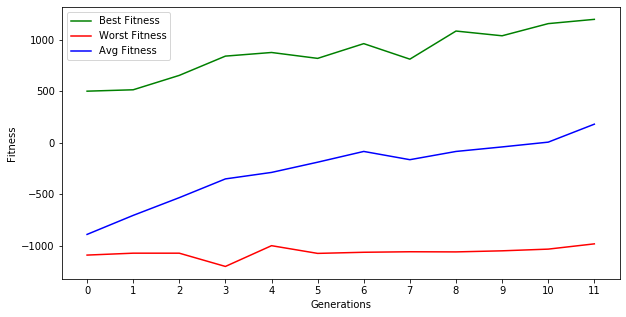

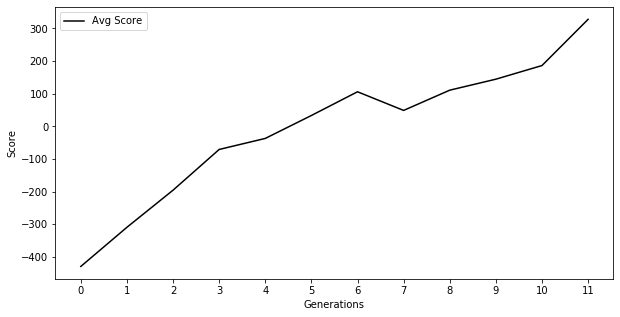

In [7]:
evolPacmanSmall = EvolutionaryPacman(layout="smallClassic", population_size=200)
evolPacmanSmall.evolve(100)

### Resultados e discussão (Small Classic)

Podemos perceber que a evolução dos indivíduos no layout "Small Classic" ocorreu muito rapidamente. Logo na 12ª geração, a população encontrou um indivíduo com 90% de win rate (critério de parada)!
O gene desse indivíduo foi guardado e pode ser visualizado a seguir:

`sum(dist_to_non_edible_ghost,sub(max(min(sum(dist_to_next_pill,count_pill),min(-1.0,dist_to_next_junction)),sub(sub(2.0,count_pill),mean(dist_to_non_edible_ghost,dist_to_next_food))),mul(min(dist_to_non_edible_ghost,dist_to_next_pill),mul(0.1,dist_to_next_food))))`

É interessante notar que o melhor indivíduo não fez uso de diversos sensores, como por exemplo: dist_to_edible_ghost,count_ghosts,ghost_before_junction,pill_before_junction, entre outros...
Isso pode ser explicado, pois talvez no layout smallClassic, realmente não seja necessário o conhecimento dessas features para obter um bom resultado. Outra possível explicação é que 12 gerações foi um número pequeno de gerações e talvez os verdadeiros melhores indivíduos (aqueles que utilizam um número maior de features ou com win rate de 100%) ainda não tinham surgido antes do critério de parada.

Os gráficos mostram que o average score e os fitness (com exceção do pior) subiram com o passar das gerações, como era de se esperar. O pior fitness não mostrou inclinação positiva, muito provavalmente devido ao fato que estamos lidando com uma população de indivíduos muito alta, e existe alta chance da reprodução dos indvíduos resultar em um indivíduo ruim. 

## Medium Classic

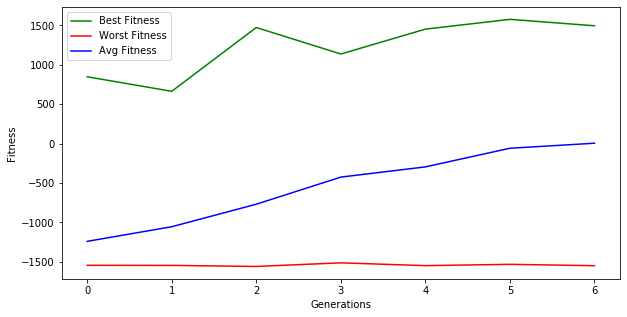

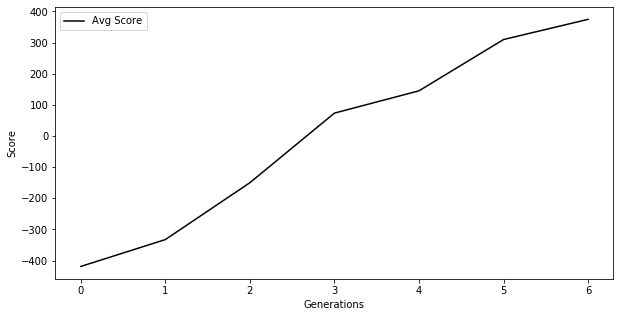

In [7]:
evolPacmanMedium = EvolutionaryPacman(layout="mediumClassic", population_size=200)
evolPacmanMedium.evolve(100)

### Resultados e discussão (Medium Classic)

Podemos perceber que a evolução dos indivíduos no layout "Medium Classic" ocorreu mais rapidamente ainda que a população do Small Classic. Apenas 7 gerações foram suficientes para encontrar um indivíduo com win rate de 90% para os 30 jogos de teste no critério de parada. 
O gene desse indivíduo foi guardado e pode ser visualizado a seguir:

`sub(min(count_pill,dist_to_next_pill),mean(sum(sub(div(pill_before_ghost,10.0),sub(dist_to_non_edible_ghost,0.5)),dist_to_next_food),10.0))`

É misterioso e ao mesmo tempo supreendente notar que esse indivíduo fez uso de apenas 5 dos 12 sensores estabelecidos, e como se não bastasse, o seu gene representa uma árvore de apenas 8 nós-folha. Ou seja, com apenas essa string pequena e com algoritmos simples que traduzem os sensores nos seus verdadeiros valores, conseguimos rodar um pacman praticamente melhor que um humano, para esse layout de mediumClassic.

Possíveis explicações do motivo de um gene tão pequeno é que, assim como o smallClassic, pode ser que o indivíduo com esse gene para esse layout específico apresenta bons resultados, mas para outros layouts, nem tanto. Para confirmar a hipótese, testamos o gene do mediumClassic para os layouts do originalClassic e smallClassic, posteriormente, aos quais obteve win rates de 30% e 100%, respectivamente (porém, este último, com average score de 918 apenas).

Os gráficos apresentam os mesmos resultados como o layout Small Classic

## Original Classic

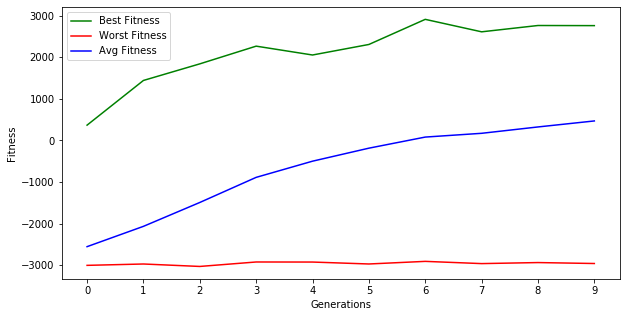

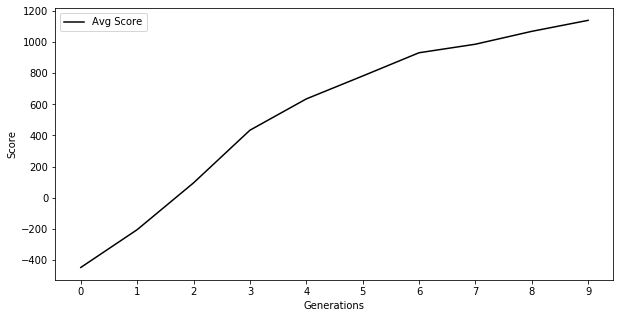

In [7]:
evolPacmanOriginal = EvolutionaryPacman(layout="originalClassic", population_size=500)
evolPacmanOriginal.evolve(10)

### Resultados e discussão (Original Classic)

O treinamento para layout Original Classic foi um pouco diferente dos outros dois últimos casos. Como esse layout é muito grande, o tempo de execução era alto e a capacidade computacional limitada. Com isso, o critério de parada adotado foi de 10 gerações. Para compensar o baixo número de gerações, aumentamos a população de 200 para 500 indivíduos, especificamente para esse caso. 

Os gráficos mostram resultados similares aos dois últimos casos, como era de se esperar. 

Antes de realizar o treinamento para o originalClassic e, sabendo anteriormente que o tempo de execução seria alto (algo em torno de 4 horas), nos questionamos se poderíamos realizar um treinamento prévio nos layouts smallClassic e mediumClassic e ir propagando as suas populações de layout em layout até que chegasse no originalClassic, de forma a "preparar" os indivíduos e não iniciá-los do zero para esse layout tão grande. Assim, esperaríamos obter uma convergência mais rápida já que a essência do jogo permanece a mesma e os sensores não mudam. Infelizmente, esse teste falhou devido ao alto consumo de memória RAM. Talvez em outros computadores ou sistemas operacionais, o teste conseguiria ser realizado para comprovar a hipótese.

# Reinforcement Learning

## O modelo

O modelo MDP utilizado foi o approximate Q-learning em que a função para o cálculo do valor de Q(s, a) é: 

`Q(s, a) = w1*f1(s, a) + w2*f2(s, a) + ... + wn*fn(s, a)`

onde fi(s, a) representa o valor da feature i para o estado atual tomando determinada ação. A ideia desse método é encontrar os pesos wi que melhor representam a função Q(s, a) de acordo com os rewards estabelecidos.

Os pesos foram atualizados utilizando a seguinte fórmula:

`wi = wi + learning_rate*diff*fi`

Onde: 

1. **learning_rate** é a taxa da aprendizado; 

2. **diff** é calculado pela seguinte fórmula: `diff = reward + gamma x argmax(Q(s', a')) - Q(s, a)` e;

3. **fi** é o valor de cada feature i, como é descrito abaixo.

**Observação**: Os pesos são atualizados de acordo com o método Temporal Difference, ou seja, para cada ação, um novo reward é calculado e o ajuste é feito. 

## As features utilizadas

As features utilizadas (total de 6) foram:

1. Distância para a comida mais próxima

2. Número de ghosts comestíveis para 1 e 2 passos ao redor do pacman

3. Número de ghosts não comestíveis para 1 e 2 passos ao redor do pacman

4. Feature binária que ativa quando há comida por perto e não há fantasmas por perto

## Reward function e política

A reward function utilizada para cada ação foi a diferença entre o score atual e o anterior, apenas. Assim, quando o pacman não come uma comida, recebe punição pois o score abaixa conforme ele se move, e quando come uma comida, ele recebe um reward positivo por ter comido. O score em si, já contempla muito os verdadeiros rewards estabelecidos pela mente humana, então decidimos manter dessa forma, como o próprio jogo propõe.   

Foi utilizada uma política Greedy para fazer a tomada das ações, assim, para cada ação possível que o pacman podia fazer em um determinado estado do jogo, aquela com o maior valor de Q(s, a) foi tomada. Não foi implementada uma política de exploração em conjunto.

## Os parâmetros

No início do processo de treinamento, foram utilizados pesos aleatórios variando entre -1 e 1 para cada feature. Foi utilizado um `learning_rate` de 0.001 e um `gamma` igual a 0.5.

O stop criteria foi similar ao usado no método de EA. Ao final de um treinamento, o agente é submetido à 20 rodadas do jogo, caso ele ganhe em 90% (18 jogos) ou realize 50 episódios, o treinamento é finalizado.

## A Classe QPacman

A classe mantém uma instância do agente principal do pacman. Logo na inicialização da classe, passamos como parâmetro um vetor de pesos aleatórios para o agente, como pode ser visto abaixo.

Cada partida é considerada um episódio e ao final de cada partida, os pesos são atualizados novamente para computar o reward de perder (-500) ou vencer (+500).

Ao final de tudo, os gráficos requisitados na descrição do trabalho são plotados e os pesos do agente que teve o melhor resultado são printados na tela.

In [8]:
class QPacman:
    def __init__(self, layout, max_episodes=50):
        self.layout = layout
        self.max_episodes = max_episodes
        LearningAgent = pacman.loadAgent("LearningAgent", True)
        self.pacman_agent = LearningAgent([-1.0,-1.0,-1.0,1.0,1.0,1.0])
        
    def getGameArgs(self, num_games=1, show_graphics=True, pacman_agent=None):
        layout = pacman.layout.getLayout(self.layout)

        ghostType = pacman.loadAgent("RandomGhost", True) #"RandomGhost"
        num_ghosts = 4 if self.layout == "originalClassic" else 2
        ghosts = [ghostType( i+1 ) for i in range( num_ghosts )]

        graphics = graphicsDisplay.PacmanGraphics(1.0, frameTime = 0.1)
        no_graphics = textDisplay.NullGraphics()
        display = graphics if show_graphics else no_graphics

        record = False

        return {
            "layout": layout, 
            "pacman": self.pacman_agent if not pacman_agent else pacman_agent, 
            "ghosts": ghosts,
            "display": display,
            "numGames": num_games, 
            "record": record
        }

    def evaluate_pacman(self, num_games=20):
        self.pacman_agent._freeze_weights(True)
        print(f"Evaluating...")
        games = pacman.runGames(**self.getGameArgs(num_games=num_games))
        mean_score = sum([game.state.getScore() for game in games]) / num_games       
        wins = [game for game in games if game.state.isWin()]
        print(f"Won: {len(wins)}/{num_games}")
        self.pacman_agent._freeze_weights(False)

        return {
            "stop": len(wins) >= 0.9*num_games,
            "score": mean_score
        }

    def run(self):
        rewards = []
        scores = []
        actions = []
        best_pacman = {"score": 0, "weights": []}

        for episode in range(self.max_episodes):
            # print stuff to 
            clear_output(wait=True)
            print(f"Running episode: {episode+1}")

            #run games
            game = pacman.runGames(**self.getGameArgs())[0]
            self.pacman_agent.update_weights(game.state)

            # to plot later
            mean_reward, num_actions = self.pacman_agent.get_data() 
            rewards.append(mean_reward)
            actions.append(num_actions)

            #evaluate best pacman until now and stop criteria
            evaluation = self.evaluate_pacman()
            scores.append(evaluation["score"])

            if best_pacman["score"] < evaluation["score"]:
                best_pacman["score"] = evaluation["score"]
                best_pacman["weights"] = self.pacman_agent.w

            if evaluation["stop"]:
                break
            
            # restart variables
            self.pacman_agent.restart()
        
        clear_output(wait=True)
        print("Best:", best_pacman["weights"])
            
        plt.rcParams["figure.figsize"] = (10,5)
        plt.xlabel("Generations")
        plt.ylabel("Reward")
        plt.xticks(range(0, self.max_episodes))
        plt.plot(rewards, 'r', label="Reward")
        plt.legend()
        plt.show()

        plt.rcParams["figure.figsize"] = (10,5)
        plt.xlabel("Generations")
        plt.ylabel("Score")
        plt.xticks(range(0, self.max_episodes))
        plt.plot(scores, 'g', label="Score")
        plt.legend()
        plt.show()

        plt.rcParams["figure.figsize"] = (10,5)
        plt.xlabel("Generations")
        plt.ylabel("Number of actions")
        plt.xticks(range(0, self.max_episodes))
        plt.plot(actions, 'b', label="Number of actions")
        plt.legend()
        plt.show()

    def run_best(self, weights):
        LearningAgent = pacman.loadAgent("LearningAgent", True)
        pacman_agent = LearningAgent(weights)
        games = pacman.runGames(**self.getGameArgs(num_games=10, show_graphics=False, pacman_agent=pacman_agent))
        avg_score = sum([game.state.getScore() for game in games]) / 10.0
        win_rate = sum([game.state.isWin() for game in games]) / 10.0
        print(f"Reinforcement Learning Pacman for {self.layout} layout results:")
        print(f"Win rate: {100*win_rate}%")
        print(f"Average score: {avg_score}")

## Small Classic

Best: [-2.133326541104507, -15.124916873222583, -13.742605473121909, 1.0, 1.0, 16.147989151541747]


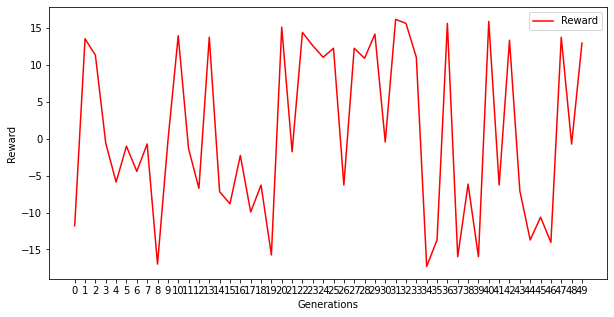

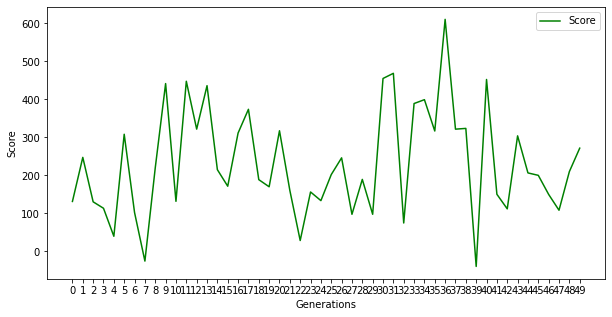

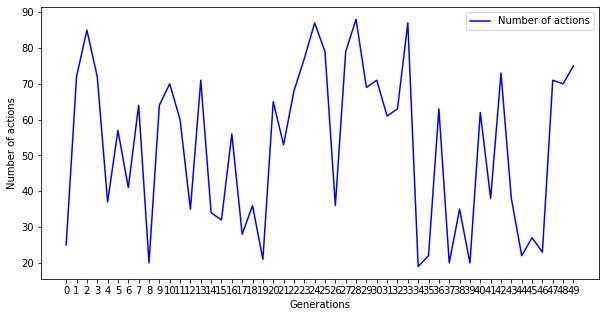

In [6]:
smallRLPacman = QPacman(layout="smallClassic")
smallRLPacman.run()

## Medium  Classic

Best: [-1.1444556415725111, -6.7260461596460175, -6.175426808181882, 11.65361389061797, 11.38432648403429, 22.698166378755833]


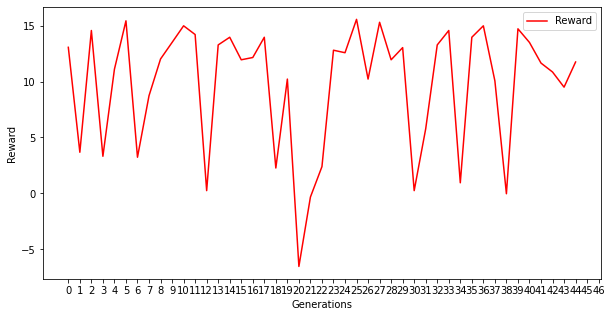

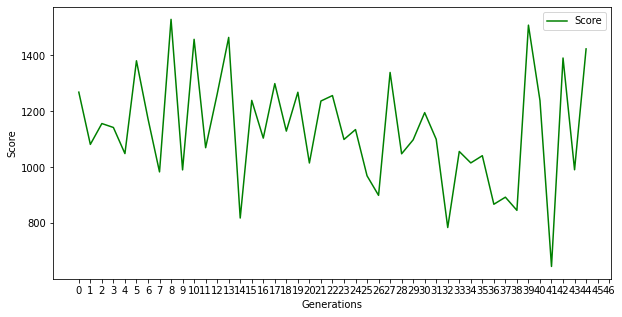

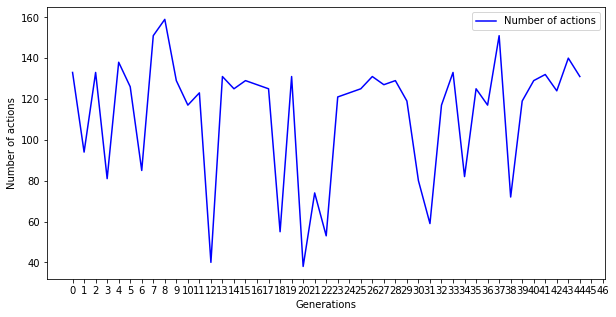

In [7]:
mediumRLPacman = QPacman(layout="mediumClassic")
mediumRLPacman.run()

## Original  Classic

Best: [-3.9069682189231725, -13.038843091330019, -12.508417082573464, 19.228646732725444, 19.4346512711667, 18.889583562179553]


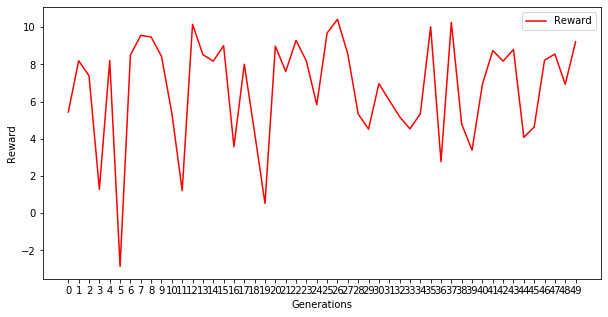

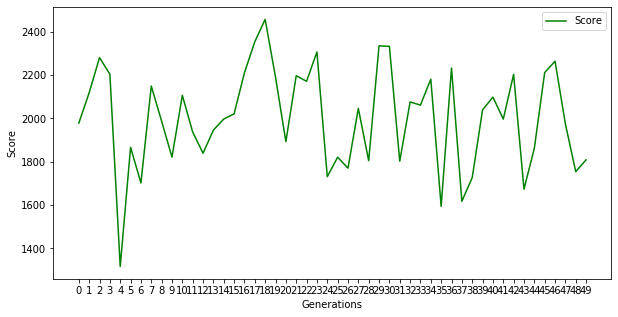

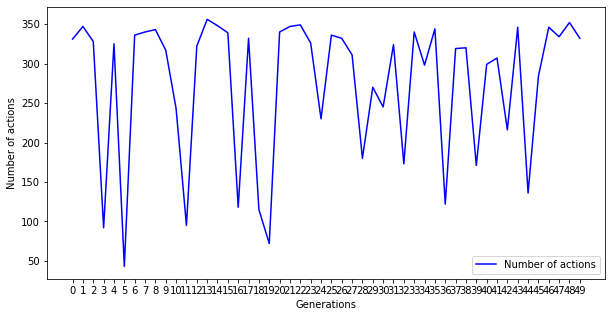

In [8]:
originalRLPacman = QPacman(layout="originalClassic")
originalRLPacman.run()

## Análise do treinamento.

O treinamento QLearning aconteceu muito rapidamente (exceto para o layout de original classic) e podemos ver que o gráfico de todos os layouts são muito caóticos, para o número de ações, rewars e principalmente para o score. 

A análise gráfica desses resultados, no entanto, não são um bom indicativo para dizer se houve melhora ou piora no agente no quesito aprendizado. Para o caso do smallClassic, por exemplo, o win rate máximo obtido foi de 60%, enquanto que o win rate máximo para o caso do mediumClassic foi de 90% e, mesmo assi, ambos os gráficos são caóticos do mesmo jeito. 

Esse resultado pode ser explicado por conta da metodologia de temporal difference empregada e pela randomicidade do problema. De certa forma, a cada tick do relógio, cada nova ação tomada, representa um novo pacman, que pode não performar muito bem em alguns jogos, mas tem uma ótima performance em outros.

# Execução final e comparação

Abaixo, fazemos a comparação entre as duas partes principais do projeto e objetos de estudo: a implementação do método de Evolutionary Algorithm e do método por Reinforcement Learning.

As execuções foram feitas de forma alternada entre EA e RL para uma ordem crescente de tamanho do layout. Após cada execução, comentários são feitos comparando as duas execuções. 

## Small Classic

In [13]:
# small
small_gene = "sum(dist_to_non_edible_ghost,sub(max(min(sum(dist_to_next_pill,count_pill),min(-1.0,dist_to_next_junction)),sub(sub(2.0,count_pill),mean(dist_to_non_edible_ghost,dist_to_next_food))),mul(min(dist_to_non_edible_ghost,dist_to_next_pill),mul(0.1,dist_to_next_food))))"
smallEAPacman = EvolutionaryPacman(layout="smallClassic", population_size=1)
smallEAPacman.run_best(small_gene)

Pacman emerges victorious! Score: 978
Pacman emerges victorious! Score: 1334
Pacman emerges victorious! Score: 1377
Pacman emerges victorious! Score: 1548
Pacman emerges victorious! Score: 1177
Pacman emerges victorious! Score: 1327
Pacman emerges victorious! Score: 1376
Pacman emerges victorious! Score: 1359
Pacman emerges victorious! Score: 1159
Evolutionary Algorithm Pacman for smallClassic layout results:
Win rate: 90.0%
Average score: 1159.9


In [40]:
small_weights = [-2.133326541104507, -15.124916873222583, -13.742605473121909, 1.0, 1.0, 16.147989151541747]
smallRLPacman = QPacman(layout="smallClassic")
smallRLPacman.run_best(small_weights)

Pacman emerges victorious! Score: 977
Pacman emerges victorious! Score: 980
Pacman emerges victorious! Score: 972
Pacman emerges victorious! Score: 982
Pacman emerges victorious! Score: 973
Pacman emerges victorious! Score: 985
Reinforcement Learning Pacman for smallClassic layout results:
Win rate: 60.0%
Average score: 519.1


### Resultados

Como podemos perceber, além do win rate para o modelo EA ter sido maior, o score de cada pacman vitorioso também é maior, por até mais de 500 pontos algumas vezes. Isso indica que o pacman evolutivo possivelmente está comendo os fantasmas após coletar uma cápsula de poder enquanto que o pacman RL não está fazendo isso.

Isso ocorre, pois o algoritmo evolutivo, leva em consideração a distância para a cápsula para fazer a tomada de decisões, enquanto que o modelo RL não implementa feature alguma que leva em consideração as cápsulas de poder, e tampouco ganha reward por comê-las. Somando isso com o fato das cápsulas (para o layout Small Classic) estarem "escondidas", ou seja, fora da rota de comida do pacman e, além disso, com o fato de que a política implementada para o agente não leva em consideração a possibilidade de exploração (apenas Greedy), nos leva a concluir que o win rate baixo do pacman RL se deve ao fato de que ele não está ingerindo as cápsulas de poder.

O que confirma mais ainda tal hipótese, é a análise feita abaixo para o caso do medium classic, em que as cápsulas se encontram na rota de comida e o win rate e average score para ambos os casos são praticamente iguais. 

**De certa forma podemos concluir que, para o caso do layout small classic, comer uma cápsula de poder aumenta o win rate e o average score**

## Medium Classic

In [43]:
# medium
medium_gene = "sub(min(count_pill,dist_to_next_pill),mean(sum(sub(div(pill_before_ghost,10.0),sub(dist_to_non_edible_ghost,0.5)),dist_to_next_food),10.0))"
mediumEAPacman = EvolutionaryPacman(layout="mediumClassic", population_size=1)
mediumEAPacman.run_best(medium_gene)

Pacman emerges victorious! Score: 1320
Pacman emerges victorious! Score: 1647
Pacman emerges victorious! Score: 1714
Pacman emerges victorious! Score: 1849
Pacman emerges victorious! Score: 1912
Pacman emerges victorious! Score: 1462
Pacman emerges victorious! Score: 1323
Pacman emerges victorious! Score: 1536
Pacman emerges victorious! Score: 1803
Evolutionary Algorithm Pacman for mediumClassic layout results:
Win rate: 90.0%
Average score: 1520.8


In [44]:
medium_weights = [-1.1444556415725111, -6.7260461596460175, -6.175426808181882, 11.65361389061797, 11.38432648403429, 22.698166378755833]
mediumRLPacman = QPacman(layout="mediumClassic")
mediumRLPacman.run_best(medium_weights)

Pacman emerges victorious! Score: 1749
Pacman emerges victorious! Score: 1518
Pacman emerges victorious! Score: 1526
Pacman emerges victorious! Score: 1351
Pacman emerges victorious! Score: 1537
Pacman emerges victorious! Score: 1351
Pacman emerges victorious! Score: 1536
Pacman emerges victorious! Score: 1553
Pacman emerges victorious! Score: 1751
Reinforcement Learning Pacman for mediumClassic layout results:
Win rate: 90.0%
Average score: 1362.0


### Resultados

No caso acima, podemos perceber que ambos os pacmans performaram muito bem, com win rate de 90% e average score praticamente iguais. 

Nada mais a acrescentar.

## Original Classic

In [45]:
original_gene = "mean(min(min(sub(mean(mean(count_pill,count_edible_ghost),min(count_non_edible_ghost,dist_to_next_pill)),max(min(dist_to_edible_ghost,5.0),count_non_edible_ghost)),sub(min(mean(dist_to_next_junction,count_pill),5.0),min(sub(dist_to_next_junction,count_non_edible_ghost),max(max(mean(dist_to_non_edible_ghost,sum(0.1,count_edible_ghost)),count_junction),count_junction)))),mul(dist_to_next_food,div(max(mean(min(max(mul(count_pill,0.5),sum(count_food,dist_to_non_edible_ghost)),dist_to_next_food),div(sum(dist_to_next_pill,min(2.0,count_non_edible_ghost)),div(sub(dist_to_non_edible_ghost,0.5),min(0.0,0.1)))),sub(mul(sum(sub(5.0,dist_to_next_junction),sum(count_junction,count_edible_ghost)),mul(sub(count_non_edible_ghost,dist_to_edible_ghost),sum(pill_before_ghost,2.0))),sum(pill_before_ghost,pill_before_ghost))),div(dist_to_next_food,sub(div(10.0,dist_to_non_edible_ghost),min(dist_to_edible_ghost,2.0)))))),max(sub(mul(sum(dist_to_next_junction,sub(sub(dist_to_non_edible_ghost,dist_to_next_food),div(2.0,5.0))),max(mean(count_non_edible_ghost,10.0),pill_before_ghost)),mul(sub(0.1,count_pill),div(dist_to_next_junction,pill_before_ghost))),min(max(mean(dist_to_next_pill,0.0),mean(mul(0.5,5.0),sub(ghost_before_junction,dist_to_non_edible_ghost))),min(div(max(max(0.1,0.5),5.0),mul(0.1,count_junction)),mul(max(dist_to_non_edible_ghost,dist_to_non_edible_ghost),count_junction)))))"
originalEAPacman = EvolutionaryPacman(layout="originalClassic", population_size=1)
originalEAPacman.run_best(original_gene)

Pacman emerges victorious! Score: 3093
Pacman emerges victorious! Score: 2750
Pacman emerges victorious! Score: 3357
Pacman emerges victorious! Score: 2705
Pacman emerges victorious! Score: 2900
Pacman emerges victorious! Score: 2430
Evolutionary Algorithm Pacman for originalClassic layout results:
Win rate: 60.0%
Average score: 2269.5


In [47]:
original_weights = [-3.9069682189231725, -13.038843091330019, -12.508417082573464, 19.228646732725444, 19.4346512711667, 18.889583562179553]
originalRLPacman = QPacman(layout="originalClassic")
originalRLPacman.run_best(original_weights)

Pacman emerges victorious! Score: 2804
Pacman emerges victorious! Score: 3044
Pacman emerges victorious! Score: 3042
Pacman emerges victorious! Score: 3277
Pacman emerges victorious! Score: 3028
Pacman emerges victorious! Score: 3252
Reinforcement Learning Pacman for originalClassic layout results:
Win rate: 60.0%
Average score: 2439.7


### Resultados

No caso do layout original classic, podemos perceber que ambos os pacmans performaram relativamente bem, apresentando novamente o mesmo win rate (60%) e average scores parecidos. 

Vale ressaltar aqui, que essa análise dos melhores pacmans, tanto para o modelo EA como para o modelo RL, não estão 100% completas, já que o layout é muito grande e o treinamento teve que ser interrompido para ambos os casos por motivos de capacidade computacional e tempo limitados. Dito isso, não podemos dizer com certeza qual modelo apresentaria o melhor resultado após ter sido 100% treinado e ter convergido. 

O que podemos discutir no entanto, para comparar as duas modelagens, é sobre a variável tempo de treinamento. Sabendo que os melhores indivíduos de cada um dos modelos performaram de maneira similar, podemos nos indagar: então qual deles apresentou o treinamento mais rápido? A resposta é com certeza, o modelo de RL, por um fator de aproximadamente 4. O modelo EA mostra aí a sua maior desvantagem, embora o modelo consiga convergir com ótimos resultados, treinar e lidar muitos indivíduos de uma vez só pode ser altamente custoso. Enquanto isso, o modelo RL não precisa se preocupar em fazer a análise de vários indivíduos, e sim, de apenas um.

## Portability

### Evolutionary Learning

In [10]:
# medium
medium_gene = "sub(min(count_pill,dist_to_next_pill),mean(sum(sub(div(pill_before_ghost,10.0),sub(dist_to_non_edible_ghost,0.5)),dist_to_next_food),10.0))"
print("EA Medium on Small Classic")
mediumEAPacman = EvolutionaryPacman(layout="smallClassic", population_size=1)
mediumEAPacman.run_best(medium_gene)
print()
print("EA Medium on Original Classic")
mediumEAPacman = EvolutionaryPacman(layout="originalClassic", population_size=1)
mediumEAPacman.run_best(medium_gene)

EA Medium on Small Classic
Pacman emerges victorious! Score: 946
Pacman emerges victorious! Score: 944
Pacman emerges victorious! Score: 859
Pacman emerges victorious! Score: 972
Evolutionary Algorithm Pacman for smallClassic layout results:
Win rate: 40.0%
Average score: 265.1

EA Medium on Original Classic
Pacman emerges victorious! Score: 2482
Pacman emerges victorious! Score: 2339
Pacman emerges victorious! Score: 2976
Pacman emerges victorious! Score: 2673
Pacman emerges victorious! Score: 3227
Pacman emerges victorious! Score: 2864
Pacman emerges victorious! Score: 2626
Evolutionary Algorithm Pacman for originalClassic layout results:
Win rate: 70.0%
Average score: 2135.2


### Reinforcement Learning

In [11]:
medium_weights = [-1.1444556415725111, -6.7260461596460175, -6.175426808181882, 11.65361389061797, 11.38432648403429, 22.698166378755833]
print("RL Medium on Small Classic")
mediumRLPacman = QPacman(layout="smallClassic")
mediumRLPacman.run_best(medium_weights)
print()
print("RL Medium on Original Classic")
mediumRLPacman = QPacman(layout="originalClassic")
mediumRLPacman.run_best(medium_weights)

RL Medium on Small Classic
Pacman emerges victorious! Score: 980
Pacman emerges victorious! Score: 974
Reinforcement Learning Pacman for smallClassic layout results:
Win rate: 20.0%
Average score: 68.0

RL Medium on Original Classic
Pacman emerges victorious! Score: 3030
Pacman emerges victorious! Score: 3044
Pacman emerges victorious! Score: 3215
Pacman emerges victorious! Score: 2865
Pacman emerges victorious! Score: 3206
Pacman emerges victorious! Score: 3227
Pacman emerges victorious! Score: 2875
Pacman emerges victorious! Score: 2668
Reinforcement Learning Pacman for originalClassic layout results:
Win rate: 80.0%
Average score: 2618.6


## Variação dos parâmetros

Para explorar as diferenças que ocorrem no treinamento dos modelos, algumas variaçÕes dos parâmetros foram feitas:

No modelo de EA, foram feitas variações em `population_size`, `elite_size` e `max_generations`. Como o treinamento do layout "Original Classic" tomava muito tempo, foi estabelecido um limite de 10 gerações (ao contrário de 100 nos outro layouts) e 500 indivíduos por geração (ao contrário de 200). Além disso, notou-se que populações muito pequenas demoravam muito tempo para convergir (mesmo nos layout menores), sendo 200 número satisfatório. Finalmente, o número de indivíduos que eram clonados entre gerações passou de top 3 para top 5, a fim de minimizar possíveis variâncias e perdas de indivíduos muito bons mas que tenham se saído mal na validação final da geração.

No modelo de RL, a única variação feita foi no parâmetro `learning_rate`. Ao colocar um valor muito alto, percebemos que, por vezes, os pesos do agente tendiam para +/- infinito, impossibilitando qualquer convergência e evolução no treinamento.

# Conclusão final

O projeto foi interessante para analisar o funcionamento dos algoritmos de evolutionary e reinforcement learning e observar as diferenças entre ambos. Notamos que, apesar de parecerem similares em um primeiro contato, possuem singularidades que muitas vezes viabilizam ou inviabilizam um ou outro, dependendo da aplicação.

O algoritmo de evolutionary learning (EA) apresentou um tempo de execução muito superior ao de reinforcement learning (RL) para atingir resultados similares (win rate) na aplicação do pacman. Além disso, é muito mais difícil interpretar a solução do EA, uma vez que ele forma uma árvore com diferentes pesos e funções que melhor se adequaram ao problema, mas que muitas vezes não possuem sentido para um ser humano. 

Apesar disso, o algoritmo de EA apresentou muito mais variabilidade (por conta da maior quantidade de indivíduos e aleatoriedade na reprodução), sendo mais flexível em explorar diferentes situações. Já o RL foi muito mais "linear" em procurar a solução ótima, de forma que é preciso implementar as situações que desejamos que o agente explore para que o mesmo o faça (visto no caso do layout small classic, onde o pacman dificilmente procurava a "power cell"). Essa exploração pode ser muito útil em aplicações em que não se saiba/não possuem solução ótima.

Em relação às escolhas das features, foi um trabalho árduo para ambos os algoritmos, sendo necessário muita pesquisa e tentativa e erro para chegarmos em modelos satisfatórios, principalmente no RL que apresentou muito problemas e foram necessários diversos ajustes por falta de resultados bons. Vale resaltar que o EA possui mais features que o RL, fato que também contribui para a maior exploração do EA citada anteriormente.

Finalmente, a fim de curiosidade, foi realizado um teste de portabilidade, onde o melhor indivíduo/agente para layout "Medium Classic" foi submetido aos layouts "Small Classic" e "Original Classic" para ambos os algoritmos. Obteve-se resultados interessantes, com win rates relativamente baixos (20% e 40%) no "Small Classic" porém win rates elevados (70% e 80%) no "Original Classic".